Onto the final stretch now. In this final notebook, it's time to deal with the historical data in other tables. Other tables like 'bureau.csv' and 'previous_application.csv' contain applicant's historical data which can be very useful and great predictor of whether an applicant will default or not. 

# Important Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.impute import SimpleImputer
import json
import lightgbm as lgb

# Explore and Prepare Data

In [2]:
# Define file paths
BUREAU_DATA_PATH = "../data/raw/bureau.csv"
BUREAU_BALANCE_DATA_PATH = "../data/raw/bureau_balance.csv"
RAW_APPLICATION_DATA_PATH = "../data/raw/application_train.csv"
ENGINEERED_DATA_PATH = "../data/processed/application_train_engineered.csv"
PREVIOUS_APPLICATIONS_DATA_PATH = "../data/raw/previous_application.csv"
CREDIT_CARD_BALANCE_DATA_PATH = "../data/raw/credit_card_balance.csv"
POS_CASH_BALANCE_DATA_PATH = "../data/raw/POS_CASH_balance.csv"
INSTALLMENTS_PAYMENTS_DATA_PATH = "../data/raw/installments_payments.csv"

### Explore bureau data

Let's take a look at how a person's credit history can directly impact their default risk

In [3]:
# Load datasets
bureau_df = pd.read_csv(BUREAU_DATA_PATH)
bureau_balance_df = pd.read_csv(BUREAU_BALANCE_DATA_PATH)
application_df = pd.read_csv(RAW_APPLICATION_DATA_PATH)

In [4]:
print("Datasets loaded successfully.")
print(f"Bureau Data Shape: {bureau_df.shape}")
print(f"Bureau Balance Data Shape: {bureau_balance_df.shape}")

Datasets loaded successfully.
Bureau Data Shape: (1716428, 17)
Bureau Balance Data Shape: (27299925, 3)


In [5]:
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [6]:
bureau_balance_df.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [7]:
bureau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [8]:
bureau_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [9]:
bureau_balance_df['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

In [10]:
bureau_df.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


Now, let's explore the relation of bureau data with the main dataset

In [11]:
# merge bureau data with application data
application_bureau_df = application_df[['SK_ID_CURR', 'TARGET']].merge(bureau_df, how='left', on='SK_ID_CURR')

In [12]:
application_bureau_df.head()

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,currency 1,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


In [13]:
application_bureau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509345 entries, 0 to 1509344
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_CURR              1509345 non-null  int64  
 1   TARGET                  1509345 non-null  int64  
 2   SK_ID_BUREAU            1465325 non-null  float64
 3   CREDIT_ACTIVE           1465325 non-null  object 
 4   CREDIT_CURRENCY         1465325 non-null  object 
 5   DAYS_CREDIT             1465325 non-null  float64
 6   CREDIT_DAY_OVERDUE      1465325 non-null  float64
 7   DAYS_CREDIT_ENDDATE     1376227 non-null  float64
 8   DAYS_ENDDATE_FACT       920652 non-null   float64
 9   AMT_CREDIT_MAX_OVERDUE  516780 non-null   float64
 10  CNT_CREDIT_PROLONG      1465325 non-null  float64
 11  AMT_CREDIT_SUM          1465322 non-null  float64
 12  AMT_CREDIT_SUM_DEBT     1242231 non-null  float64
 13  AMT_CREDIT_SUM_LIMIT    975655 non-null   float64
 14  AM

### Visualize relation between bureau features and target

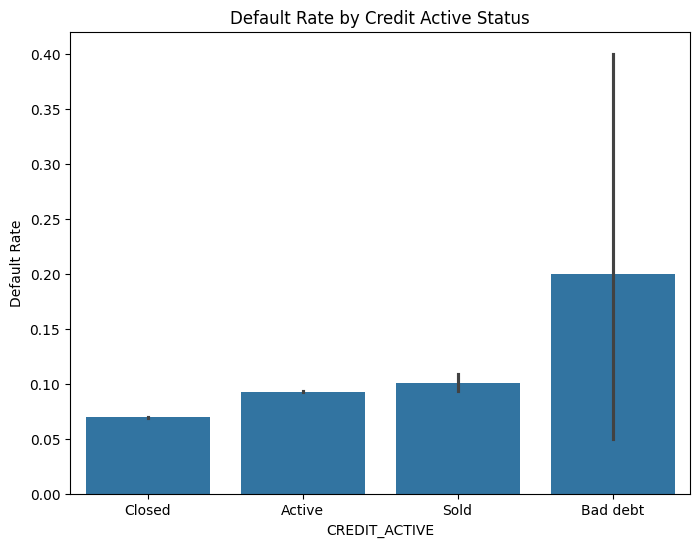

In [14]:
# Plot 1: Default Rate by Credit Active Status
plt.figure(figsize=(8, 6))
sns.barplot(x='CREDIT_ACTIVE', y='TARGET', data=application_bureau_df)
plt.title('Default Rate by Credit Active Status')
plt.ylabel('Default Rate')
plt.show()

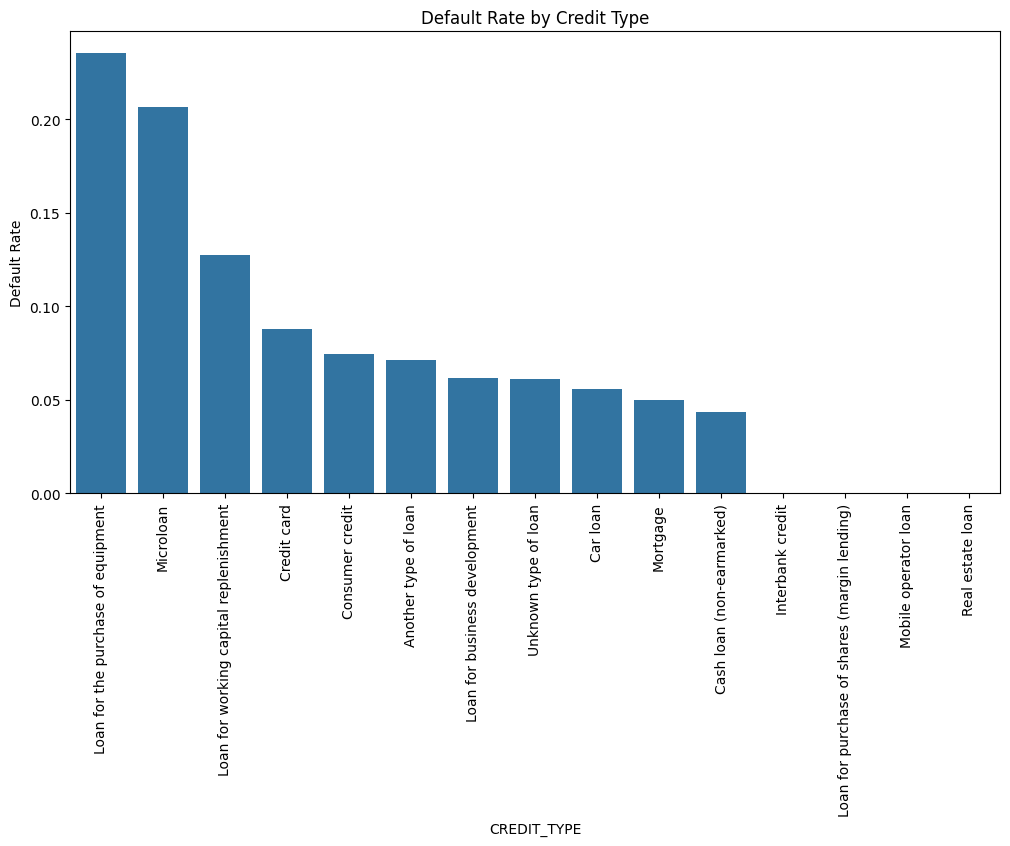

In [15]:
# Plot 2: Default Rate by Credit Type
credit_type_default_rate = application_bureau_df.groupby('CREDIT_TYPE')['TARGET'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=credit_type_default_rate.index, y=credit_type_default_rate.values)
plt.xticks(rotation=90)
plt.title('Default Rate by Credit Type')
plt.ylabel('Default Rate')
plt.show()

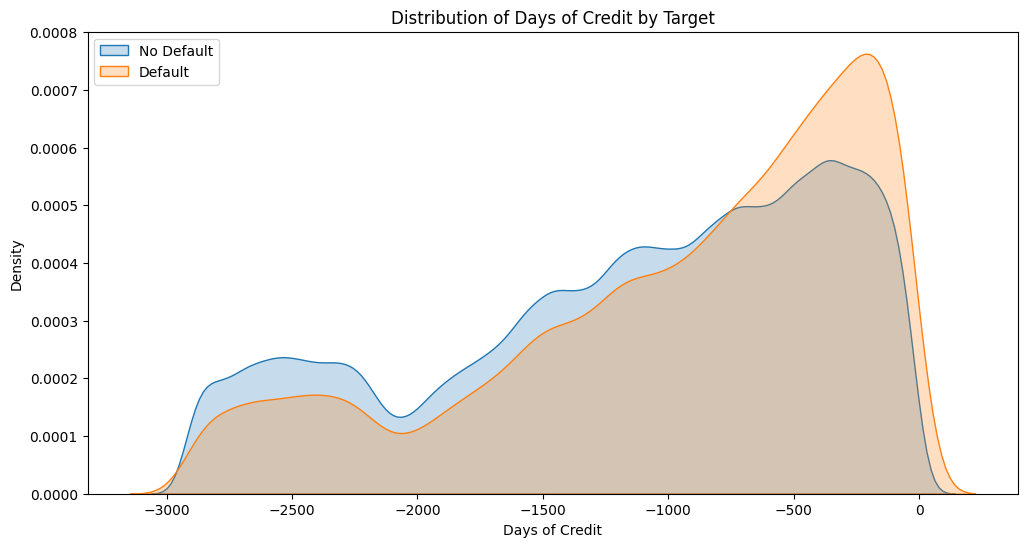

In [16]:
# Plot 3: Distribution of Days of Credit by Target
plt.figure(figsize=(12, 6))
sns.kdeplot(application_bureau_df[application_bureau_df['TARGET'] == 0]['DAYS_CREDIT'], label='No Default', fill=True)
sns.kdeplot(application_bureau_df[application_bureau_df['TARGET'] == 1]['DAYS_CREDIT'], label='Default', fill=True)
plt.title('Distribution of Days of Credit by Target')
plt.xlabel('Days of Credit')
plt.ylabel('Density')
plt.legend()
plt.show()

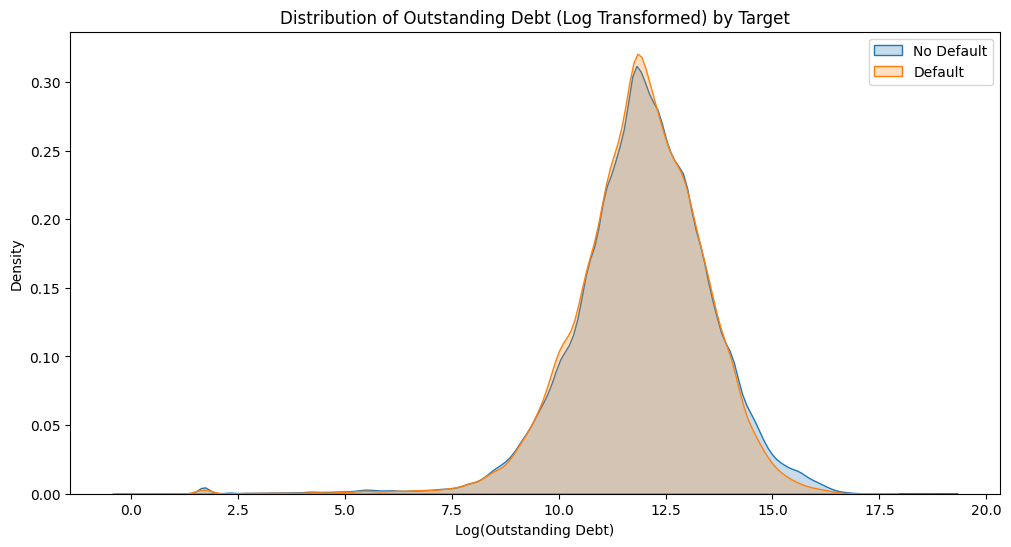

In [17]:
# Plot 4: Distribution of Outstanding Debt by Target
# Filter for non-zero debt and apply a log transformation for better visualization
debt_df = application_bureau_df[application_bureau_df['AMT_CREDIT_SUM_DEBT'] > 0].copy()
debt_df['LOG_DEBT'] = np.log1p(debt_df['AMT_CREDIT_SUM_DEBT'])
plt.figure(figsize=(12, 6))
sns.kdeplot(debt_df[debt_df['TARGET'] == 0]['LOG_DEBT'], label='No Default', fill=True)
sns.kdeplot(debt_df[debt_df['TARGET'] == 1]['LOG_DEBT'], label='Default', fill=True)
plt.title('Distribution of Outstanding Debt (Log Transformed) by Target')
plt.xlabel('Log(Outstanding Debt)')
plt.ylabel('Density')
plt.legend()
plt.show()

Let's also visualize the bureau balance data

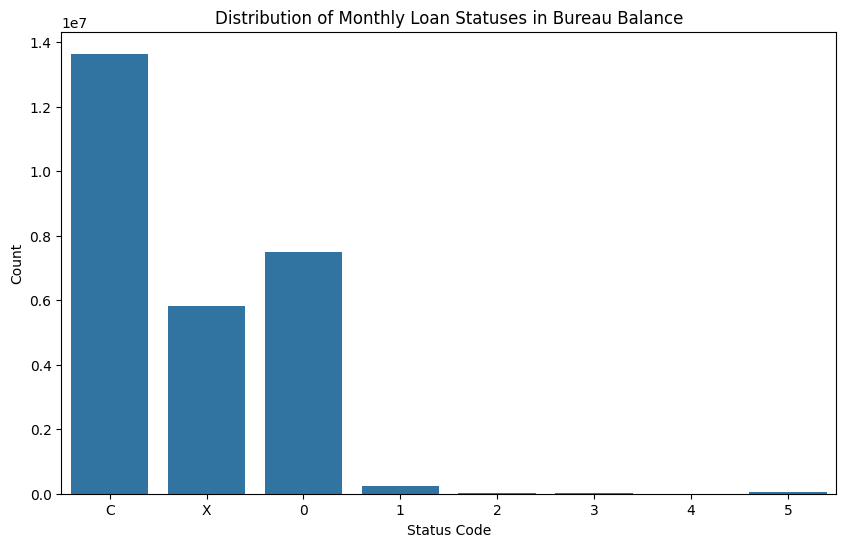

Status Code Legend:
C: Closed
X: Unknown status
0: Paid on time / No DPD
1-5: Days Past Due (DPD) increasing in severity


In [18]:
# --- Visualize the STATUS column ---
plt.figure(figsize=(10, 6))
sns.countplot(x='STATUS', data=bureau_balance_df, order=['C', 'X', '0', '1', '2', '3', '4', '5'])
plt.title('Distribution of Monthly Loan Statuses in Bureau Balance')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.show()

print("Status Code Legend:")
print("C: Closed")
print("X: Unknown status")
print("0: Paid on time / No DPD")
print("1-5: Days Past Due (DPD) increasing in severity")

This plot shows that the vast majority of past loan payments were either made on time (Status '0') or belong to loans that are now closed (Status 'C'). There are very few instances of late payments (Statuses '1' through '5').

### Explore previous application data

Now i'll explore the previous applications data before performing aggregations

In [19]:
prev_app_df = pd.read_csv(PREVIOUS_APPLICATIONS_DATA_PATH)
prev_app_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
print("Previous Applications Data Shape:", prev_app_df.shape)
print(prev_app_df.info())

Previous Applications Data Shape: (1670214, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  

In [21]:
# Separate numerical and categorical features
prev_app_numeric_cols = prev_app_df.select_dtypes(include=[np.number]).columns
prev_app_categorical_cols = prev_app_df.select_dtypes(include=['object']).columns

In [22]:
# Summary statistics for numerical features
prev_app_df[prev_app_numeric_cols].describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [23]:
# Summary for categorical features
for col in prev_app_categorical_cols:
    print(f"Value counts for {col}:")
    print(prev_app_df[col].value_counts())
    print("\n")

Value counts for NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: count, dtype: int64


Value counts for WEEKDAY_APPR_PROCESS_START:
WEEKDAY_APPR_PROCESS_START
TUESDAY      255118
WEDNESDAY    255010
MONDAY       253557
FRIDAY       252048
THURSDAY     249099
SATURDAY     240631
SUNDAY       164751
Name: count, dtype: int64


Value counts for FLAG_LAST_APPL_PER_CONTRACT:
FLAG_LAST_APPL_PER_CONTRACT
Y    1661739
N       8475
Name: count, dtype: int64


Value counts for NAME_CASH_LOAN_PURPOSE:
NAME_CASH_LOAN_PURPOSE
XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                            

### Visualize relation between prev application features and TARGET

In [24]:
# Merge previous applications with application data
application_prev_app_df = application_df[['SK_ID_CURR', 'TARGET']].merge(prev_app_df, how='left', on='SK_ID_CURR')

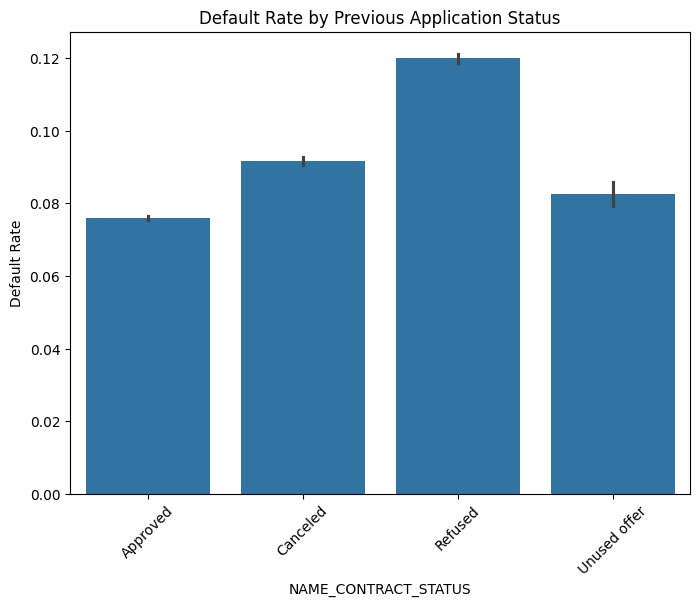

In [25]:
# Plot 1: Default Rate by Previous Application Status
plt.figure(figsize=(8, 6))
sns.barplot(x='NAME_CONTRACT_STATUS', y='TARGET', data=application_prev_app_df)
plt.title('Default Rate by Previous Application Status')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.show()

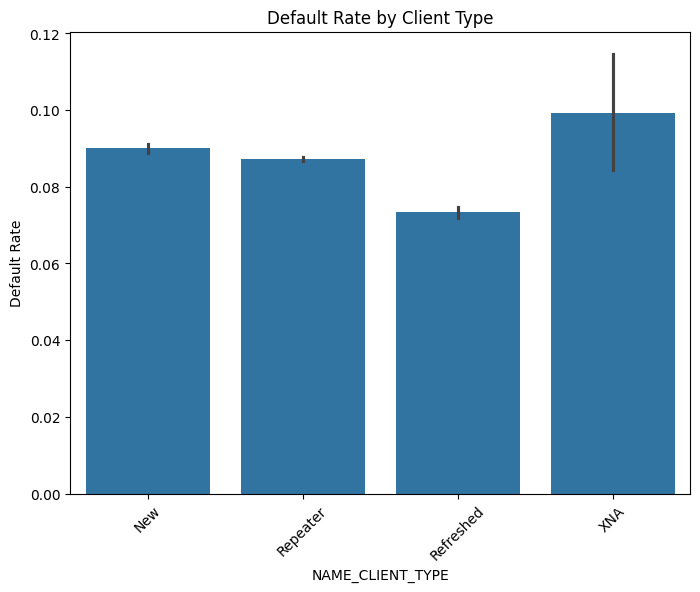

In [26]:
# Plot 2: Default Rate by Client Type
plt.figure(figsize=(8, 6))
sns.barplot(x='NAME_CLIENT_TYPE', y='TARGET', data=application_prev_app_df)
plt.title('Default Rate by Client Type')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.show()

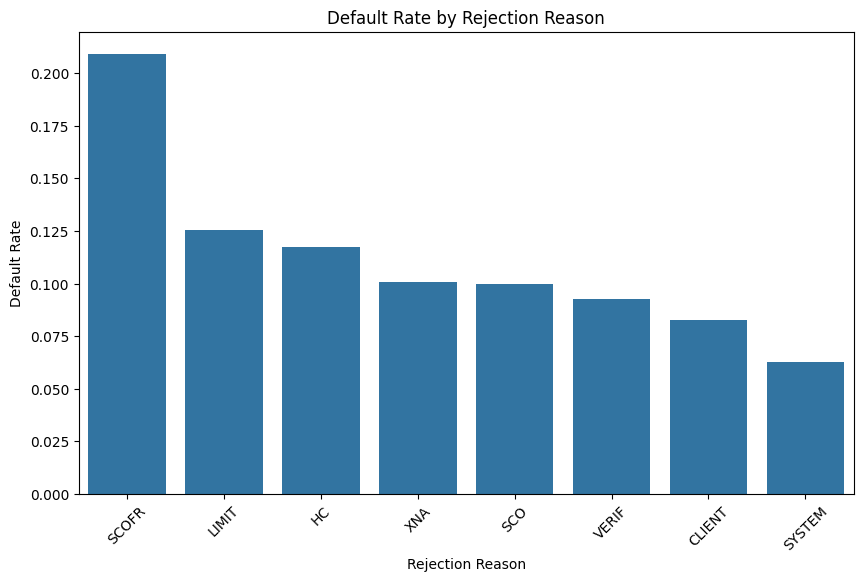

In [27]:
# Plot 3: Default Rate by Rejection Reason
# Filter out the XAP (non-applicable) entries for clearer visualization
filtered_df = application_prev_app_df[application_prev_app_df['CODE_REJECT_REASON'] != 'XAP']
rejection_reason_default_rate = filtered_df.groupby('CODE_REJECT_REASON')['TARGET'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rejection_reason_default_rate.index, y=rejection_reason_default_rate.values)
plt.title('Default Rate by Rejection Reason')
plt.ylabel('Default Rate')
plt.xlabel('Rejection Reason')
plt.xticks(rotation=45)
plt.show()

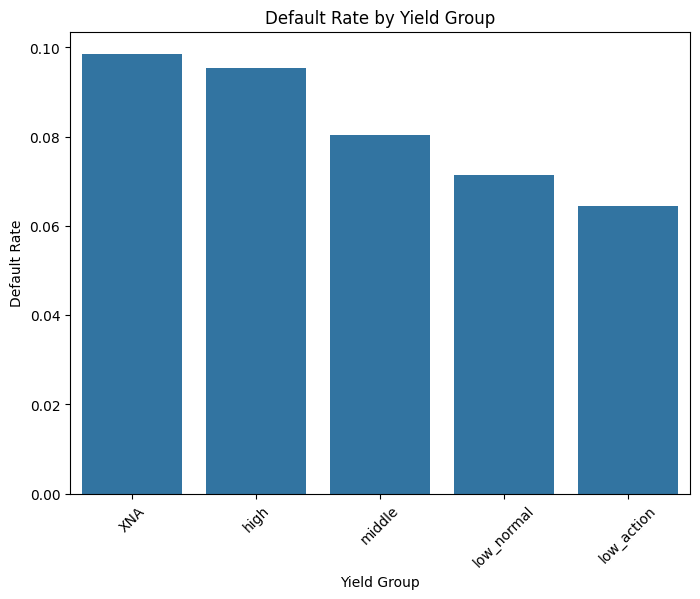

In [28]:
# Plot 4: Default Rate by Yield Group
yield_group_default_rate = application_prev_app_df.groupby('NAME_YIELD_GROUP')['TARGET'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=yield_group_default_rate.index, y=yield_group_default_rate.values)
plt.title('Default Rate by Yield Group')
plt.ylabel('Default Rate')
plt.xlabel('Yield Group')
plt.xticks(rotation=45)
plt.show()

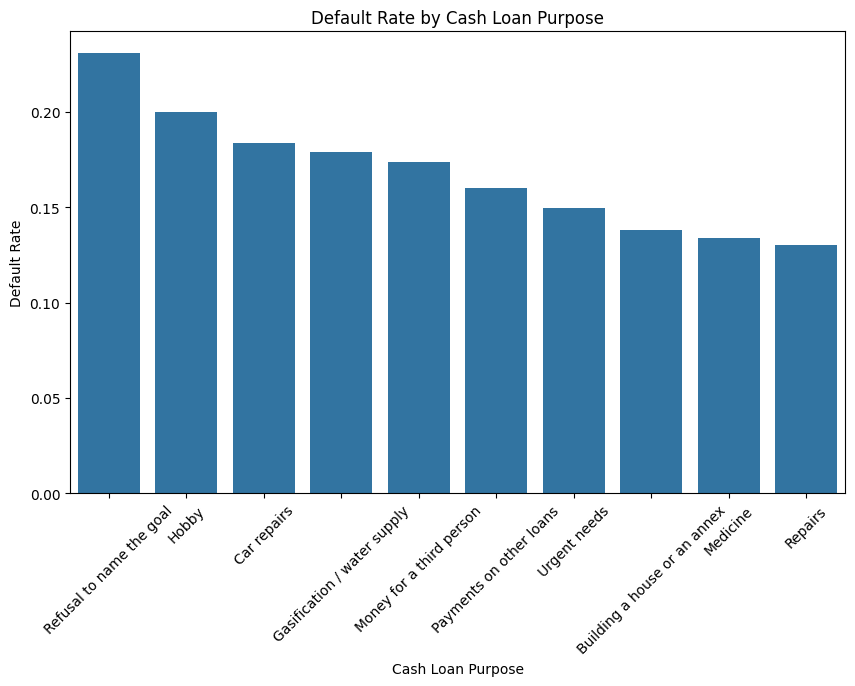

In [29]:
# Plot 5: Default Rate by Cash Loan Purpose
# Filter for specific loan purposes for a cleaner plot
loan_purpose_df = application_prev_app_df[(application_prev_app_df['NAME_CASH_LOAN_PURPOSE'] != 'XAP') &
                                            (application_prev_app_df['NAME_CASH_LOAN_PURPOSE'] != 'XNA')]
loan_purpose_default_rate = loan_purpose_df.groupby('NAME_CASH_LOAN_PURPOSE')['TARGET'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=loan_purpose_default_rate.index, y=loan_purpose_default_rate.values)
plt.title('Default Rate by Cash Loan Purpose')
plt.ylabel('Default Rate')
plt.xlabel('Cash Loan Purpose')
plt.xticks(rotation=45)
plt.show()

This completes the exploration of the supplementary tables. Now it's time to engineer powerful new features from these tables by aggregating them to the engineered dataset from previous notebooks

# ADVANCED FEATURE ENGINEERING

Now i'll define two functions, one to perform aggregations on the bureau data and the other to performm aggregations on previous application data

In [30]:
# Function to aggregate bureau data

def feature_engineer_bureau_data(df, bureau_path = BUREAU_DATA_PATH, bureau_balance_path = BUREAU_BALANCE_DATA_PATH):
    """
    Processes bureau.csv and bureau_balance.csv to create aggregated features for each SK_ID_CURR.
    """
    bureau = pd.read_csv(bureau_path)
    bureau_balance = pd.read_csv(bureau_balance_path)

    # --- Process bureau_balance.csv ---
    bb_cat = pd.get_dummies(bureau_balance, columns=['STATUS'], drop_first=True)
    bb_agg = bb_cat.groupby('SK_ID_BUREAU').agg(['mean', 'sum', 'var'])
    bb_agg.columns = pd.Index(['BB_' + e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop('SK_ID_BUREAU', axis=1, inplace=True)
    
    # --- Process bureau ---
    # Categorical aggregations
    bureau_cat_cols = bureau.select_dtypes(include='object').columns
    bureau[bureau_cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(bureau[bureau_cat_cols])
    bureau_cat_agg = pd.get_dummies(bureau.select_dtypes('object'), columns=bureau.select_dtypes('object').columns)
    bureau_cat_agg['SK_ID_CURR'] = bureau['SK_ID_CURR']
    bureau_cat_agg = bureau_cat_agg.groupby('SK_ID_CURR').agg(['mean', 'sum'])
    bureau_cat_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_cat_agg.columns.tolist()])
    
    # Numerical aggregations
    bureau_num_agg = bureau.groupby('SK_ID_CURR').agg({
        'DAYS_CREDIT': ['count', 'mean', 'max', 'min', 'sum'],
        'CREDIT_DAY_OVERDUE': ['mean', 'max', 'sum'],
        'DAYS_CREDIT_ENDDATE': ['mean', 'max'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['mean', 'sum', 'max'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum', 'max'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'AMT_ANNUITY': ['mean', 'sum', 'max'],
    })
    bureau_num_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_num_agg.columns.tolist()])
    
    # Merge all new features back to the main dataframe
    df = df.join(bureau_num_agg, how='left', on='SK_ID_CURR')
    df = df.join(bureau_cat_agg, how='left', on='SK_ID_CURR')
    
    return df

In [31]:
# Function to aggregate previous application data

def feature_engineer_previous_data(df, previous_app_path = PREVIOUS_APPLICATIONS_DATA_PATH,
                                    installments_path = INSTALLMENTS_PAYMENTS_DATA_PATH,
                                    pos_cash_path = POS_CASH_BALANCE_DATA_PATH,
                                    credit_card_path = CREDIT_CARD_BALANCE_DATA_PATH):
    """
    Processes previous_application and its related tables to create a comprehensive set of new features.
    """
    # Load all relevant tables
    prev = pd.read_csv(previous_app_path)
    installments = pd.read_csv(installments_path)
    pos_cash = pd.read_csv(pos_cash_path)
    credit_card = pd.read_csv(credit_card_path)

    # --- Process installments_payments ---
    installments['PAYMENT_PERC'] = installments['AMT_PAYMENT'] / installments['AMT_INSTALMENT']
    installments['PAYMENT_DIFF'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']
    installments_agg = installments.groupby('SK_ID_CURR').agg({
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'PAYMENT_PERC': ['mean', 'sum', 'max', 'min'],
        'PAYMENT_DIFF': ['mean', 'sum', 'max', 'min'],
        'AMT_INSTALMENT': ['mean', 'sum', 'max'],
        'AMT_PAYMENT': ['mean', 'sum', 'max'],
    })
    installments_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in installments_agg.columns.tolist()])
    df = df.join(installments_agg, how='left', on='SK_ID_CURR')

    # --- Process POS_CASH_balance ---
    pos_cash_agg = pos_cash.groupby('SK_ID_CURR').agg({
        'MONTHS_BALANCE': ['mean', 'max', 'min', 'count'],
        'SK_DPD': ['mean', 'max', 'sum'],
        'CNT_INSTALMENT_FUTURE': ['mean', 'sum', 'min']
    })
    pos_cash_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_cash_agg.columns.tolist()])
    df = df.join(pos_cash_agg, how='left', on='SK_ID_CURR')

    # --- Process credit_card_balance ---
    credit_card_agg = credit_card.groupby('SK_ID_CURR').agg({
        'AMT_BALANCE': ['mean', 'sum', 'max', 'min'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['mean', 'sum', 'max'],
        'AMT_DRAWINGS_CURRENT': ['mean', 'sum', 'max'],
        'CNT_INSTALMENT_MATURE_CUM': ['mean', 'sum', 'max'],
        'SK_DPD': ['mean', 'max', 'sum']
    })
    credit_card_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in credit_card_agg.columns.tolist()])
    df = df.join(credit_card_agg, how='left', on='SK_ID_CURR')

    # --- Process previous_application ---
    prev_cat_cols = prev.select_dtypes(include='object').columns
    prev[prev_cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(prev[prev_cat_cols])
    prev_cat = pd.get_dummies(prev.select_dtypes('object'), columns=prev.select_dtypes('object').columns)
    prev_cat['SK_ID_CURR'] = prev['SK_ID_CURR']
    prev_cat_agg = prev_cat.groupby('SK_ID_CURR').agg(['mean', 'sum'])
    prev_cat_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in prev_cat_agg.columns.tolist()])
    
    prev_num_agg = prev.groupby('SK_ID_CURR').agg({
        'AMT_ANNUITY': ['mean', 'sum', 'max', 'min'],
        'AMT_CREDIT': ['mean', 'sum', 'max', 'min'],
        'AMT_GOODS_PRICE': ['mean', 'sum', 'max'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'DAYS_DECISION': ['mean', 'max', 'min']
    })
    prev_num_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_num_agg.columns.tolist()])
    
    df = df.join(prev_num_agg, how='left', on='SK_ID_CURR')
    df = df.join(prev_cat_agg, how='left', on='SK_ID_CURR')
    
    return df

Now that these function are defined let's perform this advanced feature engineering on the previously saved engineered data, and train a new model

In [32]:
engineered_df = pd.read_csv(ENGINEERED_DATA_PATH)
with open('../config/top_features.json', 'r') as f:
    top_features = json.load(f)

engineered_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in engineered_df.columns]
base_df = engineered_df[top_features + ['SK_ID_CURR', 'TARGET']]
print("Engineered Data Shape:", base_df.shape)

Engineered Data Shape: (307511, 62)


In [33]:
# Add advanced features
df_rich = feature_engineer_bureau_data(base_df)
df_rich = feature_engineer_previous_data(df_rich)
print("Data Shape after Advanced Feature Engineering:", df_rich.shape)

Data Shape after Advanced Feature Engineering: (307511, 475)


In [34]:
# CRITICAL STEP: Replace infinity with NaN
df_rich.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_cols = df_rich.select_dtypes(include=np.number).columns.tolist()

# Impute numerical columns with median
imputer_median = SimpleImputer(strategy='median')
df_rich[numerical_cols] = imputer_median.fit_transform(df_rich[numerical_cols])

# clean feature names for LightGBM
df_rich.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_rich.columns]

In [35]:
# Prepare data for modeling
X = df_rich.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df_rich['TARGET']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display shapes of the datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (246008, 473) (246008,)
Test set shape: (61503, 473) (61503,)


In [36]:
# Power trandformation and Scaling
power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
X_train = power_transformer.fit_transform(X_train)
X_test = power_transformer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame to use feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [37]:
# Load hyperparameters
with open('../config/best_lgbm_params.json', 'r') as f:
    lgbm_params = json.load(f)

In [38]:
# Train LightGBM model
final_model = lgb.LGBMClassifier(**lgbm_params)
final_model.fit(X_train_scaled, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9287838567079353, colsample_bytree=0.6204910468966424 will be ignored. Current value: feature_fraction=0.9287838567079353
[LightGBM] [Warning] bagging_fraction is set=0.9495916039524935, subsample=0.7231683030135212 will be ignored. Current value: bagging_fraction=0.9495916039524935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9287838567079353, colsample_bytree=0.6204910468966424 will be ignored. Current value: feature_fraction=0.9287838567079353
[LightGBM] [Warning] bagging_fraction is set=0.9495916039524935, subsample=0.7231683030135212 will be ignored. Current value: bagging_fraction=0.949

,boosting_type,'gbdt'
,num_leaves,24
,max_depth,15
,learning_rate,0.14661696258280738
,n_estimators,766
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [39]:
# Evaluate model
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Final Model AUC-ROC: {final_auc:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9287838567079353, colsample_bytree=0.6204910468966424 will be ignored. Current value: feature_fraction=0.9287838567079353
[LightGBM] [Warning] bagging_fraction is set=0.9495916039524935, subsample=0.7231683030135212 will be ignored. Current value: bagging_fraction=0.9495916039524935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Final Model AUC-ROC: 0.7722


### Final feature selection loop

In [40]:
# get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns, 
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

In [41]:
results = []
feature_counts = list(range(50, 401, 50))

# Final feature selection loop
for count in feature_counts:
    selected_features = feature_importances['feature'].head(count).tolist()
    
    X_train_fs = X_train_scaled[selected_features]
    X_test_fs = X_test_scaled[selected_features]
    
    model_fs = lgb.LGBMClassifier(**lgbm_params)
    model_fs.fit(X_train_fs, y_train)
    
    y_pred_proba_fs = model_fs.predict_proba(X_test_fs)[:, 1]
    auc_fs = roc_auc_score(y_test, y_pred_proba_fs)
    
    results.append((count, auc_fs))



[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9287838567079353, colsample_bytree=0.6204910468966424 will be ignored. Current value: feature_fraction=0.9287838567079353
[LightGBM] [Warning] bagging_fraction is set=0.9495916039524935, subsample=0.7231683030135212 will be ignored. Current value: bagging_fraction=0.9495916039524935
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.9287838567079353, colsample_bytree=0.6204910468966424 will be ignored. Current value: feature_fraction=0.9287838567079353
[LightGBM] [Warning] bagging_fraction is set=0.9495916039524935, subsample=0.7231683030135212 will be ignored. Current value: bagging_fraction=0.949

In [42]:
for count, auc in results:
    print(f"Top {count} features - AUC-ROC: {auc:.4f}")

optimal_features_count = max(results, key=lambda x: x[1])[0]
print(f"Optimal number of features: {optimal_features_count}")
selected_features = selected_features[:optimal_features_count]

Top 50 features - AUC-ROC: 0.7595
Top 100 features - AUC-ROC: 0.7644
Top 150 features - AUC-ROC: 0.7677
Top 200 features - AUC-ROC: 0.7715
Top 250 features - AUC-ROC: 0.7744
Top 300 features - AUC-ROC: 0.7720
Top 350 features - AUC-ROC: 0.7730
Top 400 features - AUC-ROC: 0.7737
Optimal number of features: 250


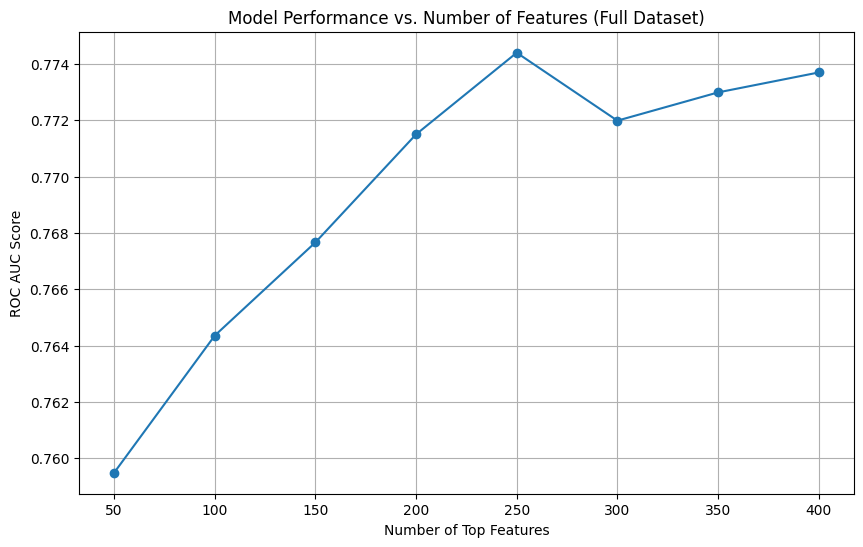

In [43]:
# Plot the results 
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df[0], results_df[1], marker='o')
plt.title('Model Performance vs. Number of Features (Full Dataset)')
plt.xlabel('Number of Top Features')
plt.ylabel('ROC AUC Score')
plt.grid(True)
plt.show()

The model's performance peaks with an AUC score of 0.7744 using the top 250 features. Adding more features beyond this point (like 300 or 400) does not improve the score and only adds unnecessary complexity, so 250 is the clear "sweet spot" for performance and efficiency.

Save the final top features

In [44]:
with open('../config/final_top_features.json', 'w') as f:
    json.dump(selected_features, f)

print(f"Top {optimal_features_count} features saved successfully.")

Top 250 features saved successfully.
